# Ontologies and their Annotations to Vectors (OPA2Vec)

In this part of the tutorial we will apply syntactic approaches to encode ontologies, the entities that are associated with them (in the sense of "GO annotations"), and the annotation properties and their values. Syntactic embedding functions also use neural language models (such as Word2Vec) but apply them to axioms themselves. As language models, they can also take natural language components in ontologies into account, in particular labels, synonyms, or definitions. For this purpose, it is useful to first train the neural language models on relevant natural language text and then refine the function using the ontology content.

OPA2Vec is a tool that combines this workflow and provides several pre-trained models that can be used for this purpose. Here, we apply OPA2Vec on yeast proteins and their GO associations. The inputs are the ontology (OBO or OWL), the associations between some entities and the ontology classes, the reasoner to use (if any), and the file to write the embedding vectors to. OPA2Vec also has a number of optional arguments you can find with the `-help` option.

In [2]:
!cd opa2vec && python2 runOPA2Vec.py -ontology ../data/go.obo -associations ../data/yeast-assoc.txt -reasoner elk -outfile ../data/yeast.vec

***********OPA2Vec Running ...***********

***********Ontology Processing ...***********

SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
[Fatal Error] :1:1: Content is not allowed in prolog.
Loading of Axioms ...
Loading ...
    1%
    2%
    3%
    4%
    5%
    7%
    8%
    10%
    12%
    14%
    16%
    18%
    20%
    22%
    24%
    26%
    28%
    30%
    32%
    35%
    37%
    40%
    43%
    45%
    47%
    50%
    52%
    55%
    57%
    60%
    62%
    64%
    67%
    69%
    71%
    74%
    76%
    79%
    82%
    85%
    88%
    90%
    93%
    96%
    99%
    ... finished
    ... finished
Property Saturation Initialization ...
    ... finished
Reflexive Property Computation ...
    ... finished
Object Property Hierarchy and Composition Computation ...
    ... finished
Context Initialization ...
    ... finishe

We now have the embedding vectors in `data/yeast.vec`; because we use a pre-trained model, this file also contains a large amount of other embeddings that are not in any of the ontologies -- one embedding for every word in MEDLINE abstracts. So we first have to find the embedding vectors we want:

In [3]:
import numpy as np
import pandas as pd

with open('data/yeast-entities.txt') as f:
    content = f.readlines()
content = [x.strip() for x in content] 


embeddings = pd.read_csv('data/yeast.vec', header = None, skiprows = 1, sep = ' ')
embds_data = embeddings.values
embeddings_dict = dict(zip(embds_data[:,0],embds_data[:,1:-1]))
yeast_dict = {}
for i in content:
    if i in embeddings_dict:
        yeast_dict[i] = embeddings_dict[i]


Now we do the same thing we did before: visualize the embeddings using a TSNE plot.

In [4]:
from matplotlib import pyplot as plt
#from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as TSNE

size = len(yeast_dict['4932.Q0045'])
embeds = np.zeros((len(yeast_dict), size), dtype=np.float32)

for i, emb in enumerate(yeast_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(yeast_dict.keys()):
    nodemap[i] = m

X = TSNE(n_components=2, verbose=1, n_iter=2500, n_jobs=8).fit_transform(embeds)


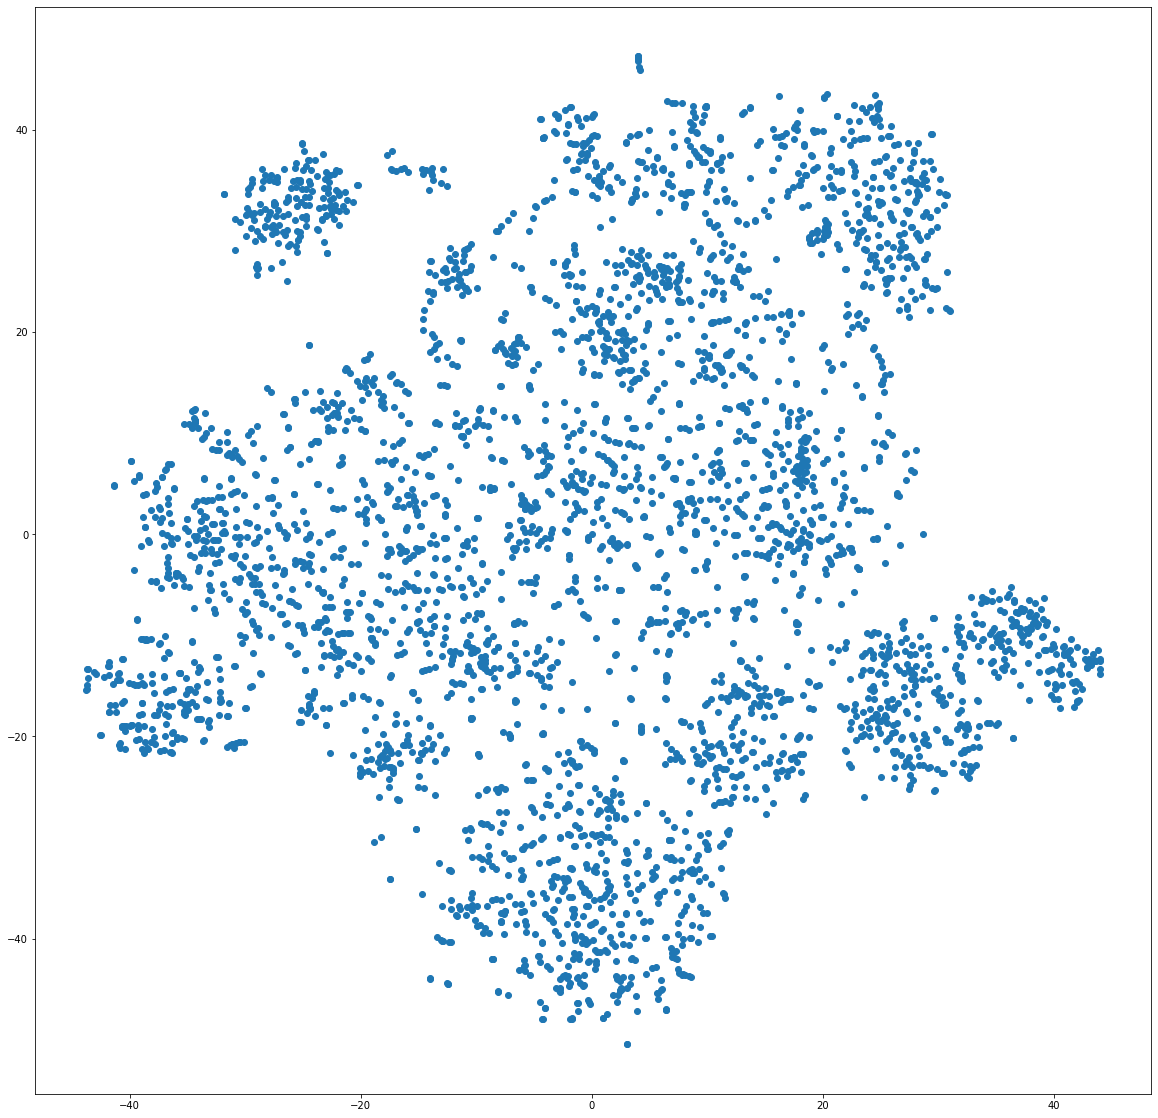

In [5]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(20, 20))
plt.scatter(X[:, 0], X[:, 1], marker='o')


Depending on how many iterations you performed for the TSNE, the plot will look somewhat separated and you may identify some clusters. We can try to identify if there is any biological significance to these clusters by coloring them with some known labels; we use the EC classification of enzymes, as before.

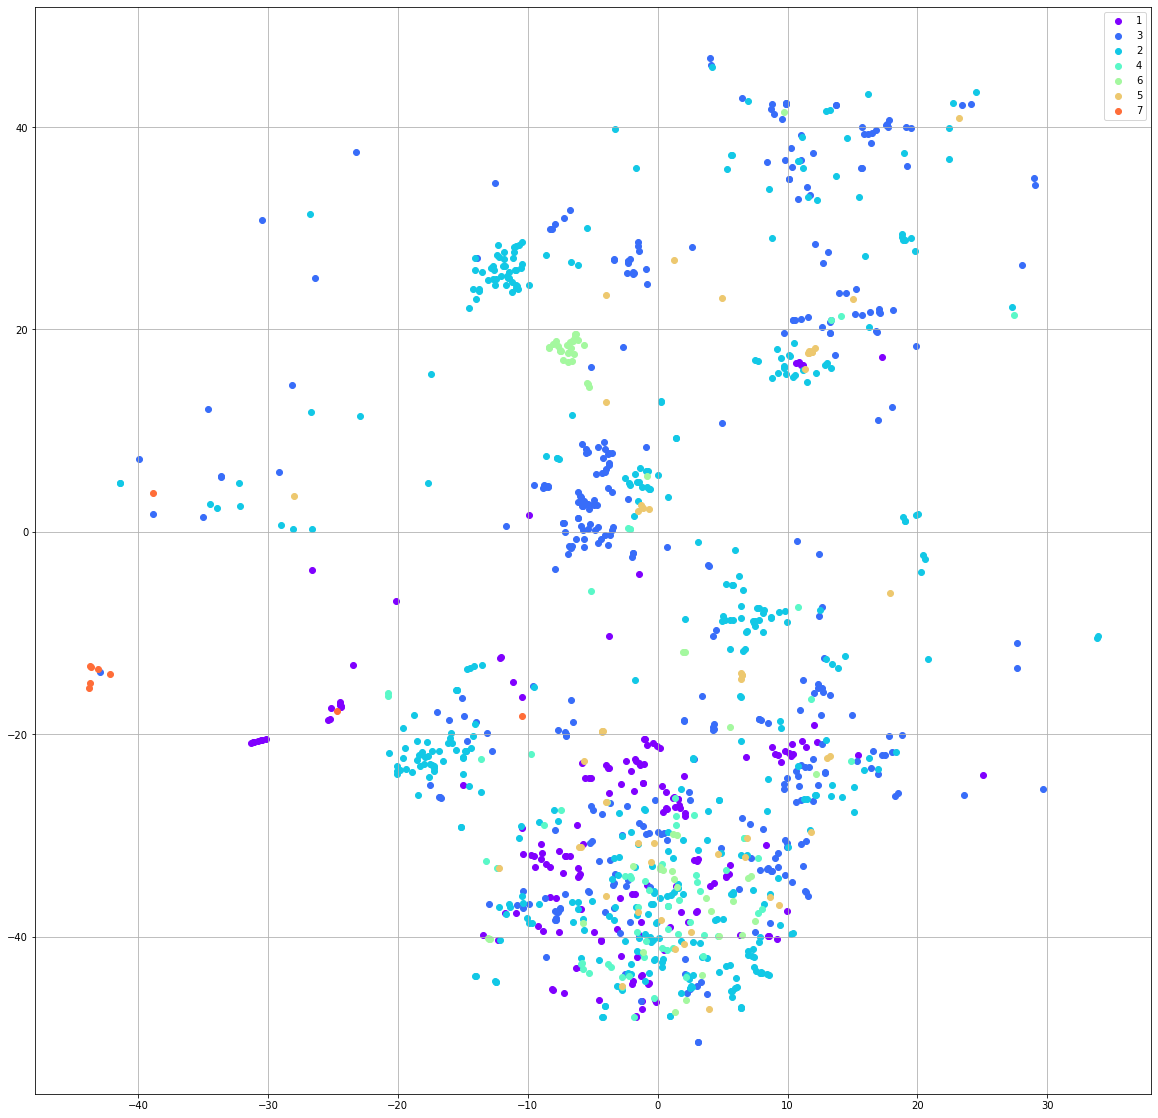

In [6]:
import matplotlib.pyplot as plt

ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = '{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[k, 0])
        classes[ec][1].append(X[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.show()


You should be able to recognize _some_ clusters that clearly correspond to EC numbers, while other groups of proteins will be rather mixed. We could test different labels -- maybe participation in pathways, neighborhood in interaction networks, InterPro domains -- and see if we can identify a label for these groups. We can also improve the grouping a bit more by applying the TSNE only to enzymes (we did apply it to all proteins before and then ignored the non-enzymes) which may make it easier to identify groups that correspond to EC numbers.

In [7]:
ec_dict = {}
for prot in ec_numbers:
    if prot in yeast_dict:
        ec_dict[prot] = yeast_dict[prot]
        
size = len(yeast_dict['4932.Q0045'])
embeds = np.zeros((len(ec_dict), size), dtype=np.float32)

for i, emb in enumerate(ec_dict.values()):
    embeds[i, :] = emb
nodemap = {}
for i, m in enumerate(ec_dict.keys()):
    nodemap[i] = m
    

X = TSNE(n_components=2, verbose=1, n_iter=5000, n_jobs=8).fit_transform(embeds)


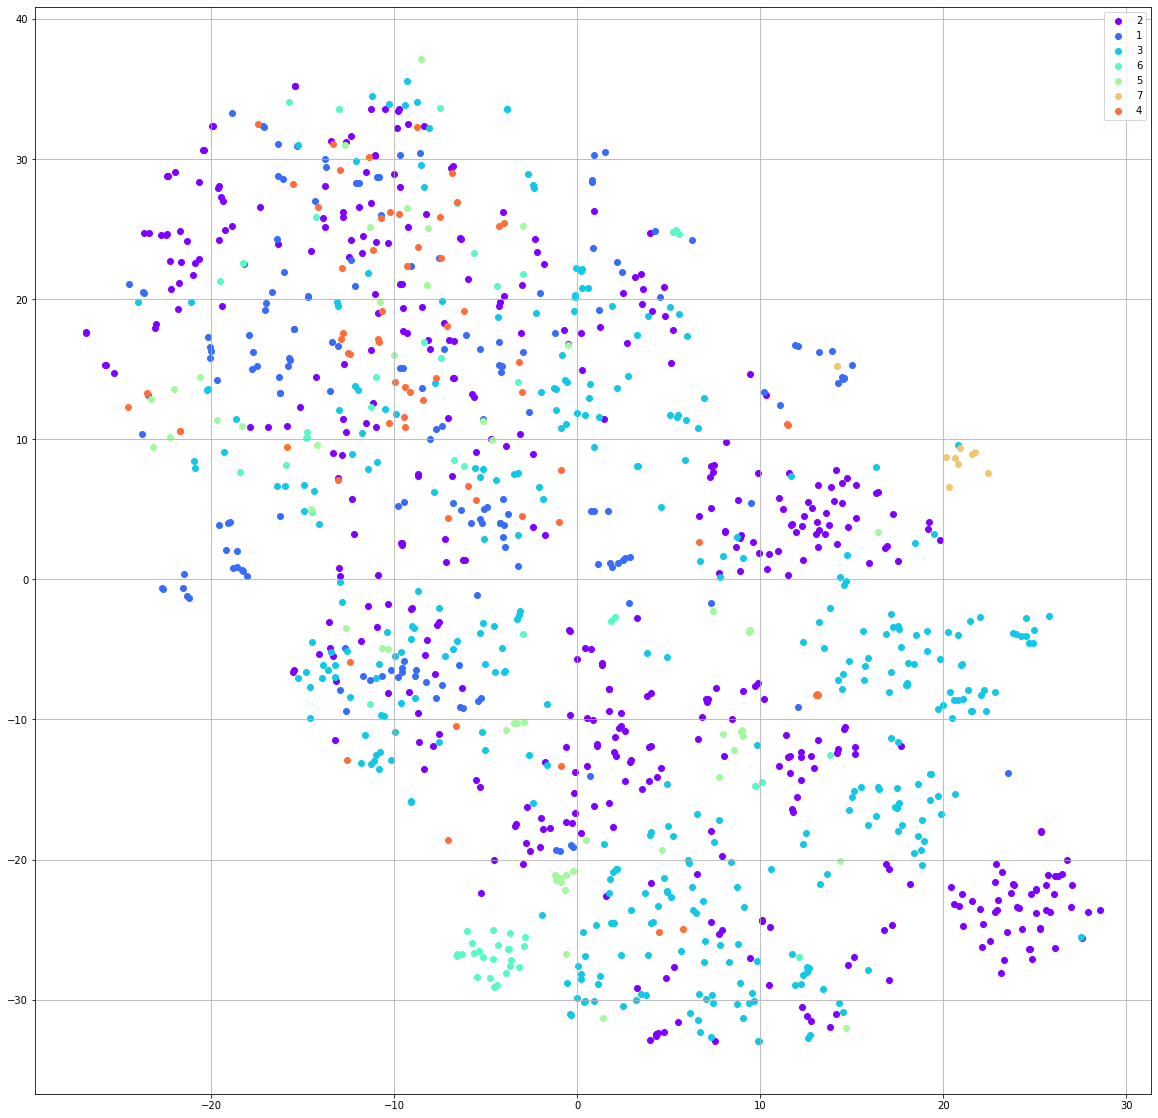

In [8]:
classes = {'0': [[], []]}
for item in nodemap.items():
    k, v = item
    if v in ec_numbers:
        ec = ec_numbers[v].split('.')[0]
        if ec not in classes:
            classes[ec] = [[], []]
        classes[ec][0].append(X[k, 0])
        classes[ec][1].append(X[k, 1])
        
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
fig, ax = plt.subplots(figsize=(20, 20))

for ec, items in classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.show()
